In [1]:
# Install PaddlePaddle (CPU) and PaddleOCR. Use --quiet for cleaner logs.
# If you have a GPU with CUDA and want GPU acceleration, replace the first line per Paddle docs.
import sys, subprocess

def pip_install(packages):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", *packages])

try:
    import paddleocr  # type: ignore
except Exception:
    pip_install(["paddlepaddle==2.6.1", "paddleocr>=2.7.0"])  # pin core for stability

print("PaddleOCR installed and ready.")


PaddleOCR installed and ready.


In [2]:
from pathlib import Path
from typing import List, Tuple, Dict, Any

import os
import io
import json
import csv

# Robust PaddleOCR imports across versions/environments
try:
    from paddleocr import PaddleOCR, draw_ocr  # type: ignore
except Exception:
    from paddleocr import PaddleOCR  # type: ignore
    try:
        from paddleocr.tools.infer.utility import draw_ocr  # type: ignore
    except Exception:
        try:
            from paddleocr.ppocr.utils.visual import draw_ocr  # type: ignore
        except Exception:
            draw_ocr = None  # type: ignore

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Resolve a TTF font for draw_ocr; fall back gracefully
DEFAULT_FONTS = [
    # Common Windows fonts
    str(Path(os.getenv("WINDIR", "C:/Windows")) / "Fonts" / "arial.ttf"),
    str(Path(os.getenv("WINDIR", "C:/Windows")) / "Fonts" / "segoeui.ttf"),
    # DejaVu for many environments
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
]

def resolve_font_path() -> str:
    for font_path in DEFAULT_FONTS:
        if Path(font_path).exists():
            return font_path
    return ""  # draw_ocr can work without font, but text overlay may not render properly

FONT_PATH = resolve_font_path()

# Utility: display image inline

def show_image(img_array: np.ndarray, title: str = "") -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(img_array)
    plt.title(title)
    plt.axis('off')
    plt.show()



In [ ]:
# Initialize the newest PaddleOCR pipeline.
# Notes:
# - As of 2025, PaddleOCR defaults to the latest PP-OCR series (v5+) when not specifying ocr_version.
# - Set lang='en' for English invoices. Use 'ch', 'en', or multi-lang like 'en' as needed.
# - cls=True enables text direction classifier.
# - use_angle_cls=True ensures rotated text correction.
# - det_limit_side_len can be raised for high-res docs, but increases memory.

ocr = PaddleOCR(
    lang='en',
    use_angle_cls=True,
    rec=True,
    det=True,
    # You can set ocr_version explicitly if desired, e.g., 'PP-OCRv4' or 'PP-OCRv5'
    # ocr_version='PP-OCRv5',
)

print("OCR initialized. lang=en, angle_cls=True")

[2025/09/23 09:12:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\AWright/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\AWright/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text

In [ ]:
from dataclasses import dataclass

@dataclass
class OCRBox:
    points: list  # 4-point polygon [[x1,y1],...]
    text: str
    confidence: float


def ocr_image(image_path: str, return_visual: bool = True) -> dict:
    """Run OCR on a single image and optionally return a visualization.

    Returns dict with keys: 'path', 'items' (list[OCRBox]), 'image' (np.ndarray or None).
    """
    global ocr
    results = ocr.ocr(image_path, cls=True)

    items = []
    if results and len(results) > 0 and results[0] is not None:
        for line in results[0]:
            box = line[0]
            text = line[1][0]
            score = float(line[1][1])
            items.append(OCRBox(points=box, text=text, confidence=score))

    visual = None
    if return_visual and 'draw_ocr' in globals() and draw_ocr is not None:
        image = np.array(Image.open(image_path).convert('RGB'))
        boxes = [it.points for it in items]
        texts = [it.text for it in items]
        scores = [it.confidence for it in items]
        visual = draw_ocr(image, boxes, texts, scores, font_path=FONT_PATH)
    elif return_visual:
        print("draw_ocr not available; skipping visualization")

    return {
        "path": image_path,
        "items": items,
        "image": visual,
    }

# Quick smoke test helper

def print_ocr_summary(result: dict, max_lines: int = 20):
    print(f"Image: {result['path']}")
    print(f"Detections: {len(result['items'])}")
    for it in result['items'][:max_lines]:
        print(f"- {it.text} (conf={it.confidence:.3f})")


In [5]:
def ocr_directory(
    folder: str,
    patterns=(".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp", ".pdf"),
    save_csv: str | None = None,
    visualize: bool = False,
):
    """Run OCR over a directory and optionally write a CSV.

    CSV columns: path, index, text, confidence, box_json
    """
    folder_path = Path(folder)
    if not folder_path.exists():
        raise FileNotFoundError(folder)

    rows = []
    images = []

    for ext in patterns:
        for p in sorted(folder_path.rglob(f"*{ext}")):
            res = ocr_image(str(p), return_visual=visualize)
            if visualize and res["image"] is not None:
                images.append((str(p), res["image"]))
            for idx, item in enumerate(res["items"]):
                rows.append({
                    "path": str(p),
                    "index": idx,
                    "text": item.text,
                    "confidence": item.confidence,
                    "box_json": json.dumps(item.points),
                })

    if save_csv:
        csv_path = Path(save_csv)
        csv_path.parent.mkdir(parents=True, exist_ok=True)
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=["path", "index", "text", "confidence", "box_json"])
            writer.writeheader()
            for row in rows:
                writer.writerow(row)
        print(f"Wrote {len(rows)} rows to {csv_path}")

    # Optionally display a few visual outputs
    if visualize and images:
        for img_path, vis in images[:5]:
            show_image(vis, title=img_path)

    return rows


[2025/09/19 10:45:45] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.6536595821380615
[2025/09/19 10:45:46] ppocr DEBUG: cls num  : 60, elapsed : 0.267627477645874
[2025/09/19 10:45:48] ppocr DEBUG: rec_res num  : 60, elapsed : 2.893129825592041
Image: C:\Users\AWright\OneDrive - Kahua, Inc\Projects\invoice\construction-invoice-template-1x.png
Detections: 60
- Zylker Masterworks (conf=0.999)
- 14B, Northern Street (conf=0.998)
- Greater South Avenue (conf=1.000)
- New York 10001 (conf=0.990)
- U.S.A (conf=0.992)
- INVOICE (conf=0.999)
- Invoice# (conf=0.999)
- Bill To (conf=0.996)
- INV-000001 (conf=0.980)
- Michael Williams. (conf=0.954)
- 789 Oak Ave (conf=1.000)
- Chicago (conf=1.000)
- 60601 IL (conf=0.959)
- United States (conf=1.000)
- Invoice Date (conf=0.996)
- Terms (conf=0.999)
- Due Date (conf=0.999)
- O1 Jun 2024 (conf=0.985)
- Net 30 (conf=0.999)
- O1 Jul 2024 (conf=0.964)
- Item & Description (conf=0.997)
- Qty (conf=1.000)
-  Rate (conf=0.928)
- Tax% (conf=0.992)
- Amount (

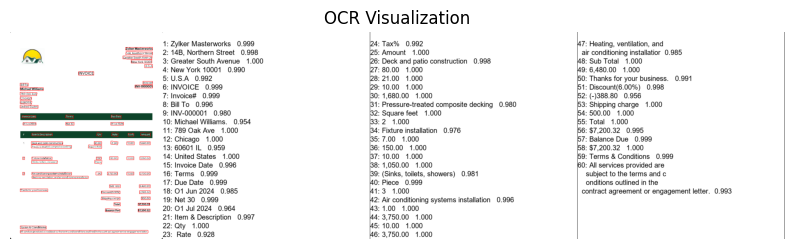

In [7]:
# Demo: set a path to an image of an invoice and run OCR
# Example: r"C:\\path\\to\\invoice.jpg" or a PNG/JPG in this directory

demo_image = r"C:\Users\AWright\OneDrive - Kahua, Inc\Projects\invoice\construction-invoice-template-1x.png"  # TODO: set path

if demo_image and Path(demo_image).exists():
    res = ocr_image(demo_image, return_visual=True)
    print_ocr_summary(res, max_lines=30)
    if res["image"] is not None:
        show_image(res["image"], title="OCR Visualization")
else:
    print("Set demo_image to a valid image path to run the demo.")


In [1]:
pip freeze

absl-py==2.3.1
accelerate==1.3.0
ace_tools==0.0
acres==0.5.0
aenum==3.1.15
aiofiles==24.1.0
aiohappyeyeballs==2.4.6
aiohttp==3.11.12
aiohttp-retry==2.9.1
aiosignal==1.3.2
aistudio_sdk==0.3.5
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
alembic==1.15.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyascii==0.3.3
anyio==3.7.1
appdirs==1.4.4
argcomplete==3.6.2
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asgiref==3.9.1
astor==0.8.1
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.5
attr==0.3.1
attrdict==2.0.1
attrs==25.3.0
audioread==3.0.1
av==14.1.0
azure-core==1.35.0
azure-storage-blob==12.25.1
babel==2.17.0
backoff==2.2.1
bce-python-sdk==0.9.42
bcrypt==4.3.0
beautifulsoup4==4.13.4
behave==1.2.6
bing-image-downloader==1.1.2
bitsandbytes==0.45.5
black==25.1.0
bleach==5.0.1
blinker==1.9.0
boto==2.49.0
boto3==1.37.4
botocore==1.37.4
Brotli==1.1.0
bs4==0.0.2
CacheControl==0.14.3
cachetools==5.5.2
cairocffi==1.7.1
CairoSVG==2.8.2
cattrs==25.